In [1]:
import pickle

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings

import funciones_auxiliares_hito_2 as aux

warnings.filterwarnings("ignore")
sns.set_style()
plt.rcParams["figure.figsize"] = (20, 10)

# Modelacion

## Carga de datos preprocesados

In [2]:
df = pd.read_csv("input/training_tweets.csv").drop(columns="Unnamed: 0")
df["sentiment"] = aux.codificar_sentimientos(df["sentiment"])
df["procesados_lema"] = df.content.str.lower().apply(aux.preprocesar_texto_lema)
df_lema = aux.obtener_100_palabras_mas_frecuentes(df["procesados_lema"])


## Optimizacion

- La optimizacion consistira en filtrar el numero de palabras segun su frecuencia. Esto permitira
reducir la complejidad computacional, esperando tener un desempeno del modelo similar a los modelos
sin optimizacion.

In [3]:
largo_df = df.shape[0]
filtro_frecuencias = int(round(largo_df * 0.0004, 0))

In [4]:
palabras_a_filtrar = df_lema.query("conteo < @filtro_frecuencias")
palabras_restantes = df_lema.query("conteo >= @filtro_frecuencias")
cambio_en_palabras = df_lema.shape[0] - palabras_a_filtrar.shape[0]
LISTA_PALABRAS_A_DEJAR = set(palabras_restantes.palabra.to_list())

print(f"Las palabras a filtrar son:\n{palabras_a_filtrar}\n")
print(f"Se pasara de {df_lema.shape[0]} a {cambio_en_palabras} palabras")


Las palabras a filtrar son:
            palabra  conteo
2006             ½ï      11
2007             dh      11
2008             pa      11
2009           melt      11
2010         centre      11
...             ...     ...
37676    hysterical       1
37677     hypocrite       1
37678  hypnoticzexy       1
37679      hypnosis       1
37680     lilmickee       1

[35675 rows x 2 columns]

Se pasara de 37681 a 2006 palabras


- Por lo tanto, se puede ver una disminucion considerable en la cantidad de palabras a analizar
en cada modelo predictivo.

- El filtro de palabras se aplicara en el objeto CountVectorizer con el parametro vocabulary.

In [5]:
X = CountVectorizer(
    stop_words="english", vocabulary=LISTA_PALABRAS_A_DEJAR
).fit_transform(df["procesados_lema"])
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.335, random_state=1
)

## Redeclaracion de grillas y modelos, y entrenamiento

In [6]:
grilla_logistic = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
}

grilla_naive_bayes = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "fit_prior": [True, False],
}

grilla_arbol_clasificacion = {
    "max_depth": range(3, 11),
    "max_leaf_nodes": range(1, 6),
    "criterion": ["gini", "entropy"],
}

grilla_random_forest = {
    "max_depth": range(5, 11),
    "n_estimators": range(500, 1001, 100),
    "max_features": ["sqrt", "log2"],
}

grilla_gradient_boosting = {
    "max_depth": range(5, 11),
    "learning_rate": [0.001, 0.01, 0.1, 1],
}


modelo_logistic = GridSearchCV(
    LogisticRegression(),
    grilla_logistic,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

modelo_naive_bayes = GridSearchCV(
    MultinomialNB(), grilla_naive_bayes, cv=5, scoring="accuracy", n_jobs=-1
)

modelo_arbol = GridSearchCV(
    DecisionTreeClassifier(),
    grilla_arbol_clasificacion,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

modelo_random_forest = GridSearchCV(
    RandomForestClassifier(), grilla_random_forest, cv=5, scoring="accuracy", n_jobs=-1
)


modelo_gradient_boosting = GridSearchCV(
    GradientBoostingClassifier(),
    grilla_gradient_boosting,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
)

## Entrenamiento de todos los modelos

--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


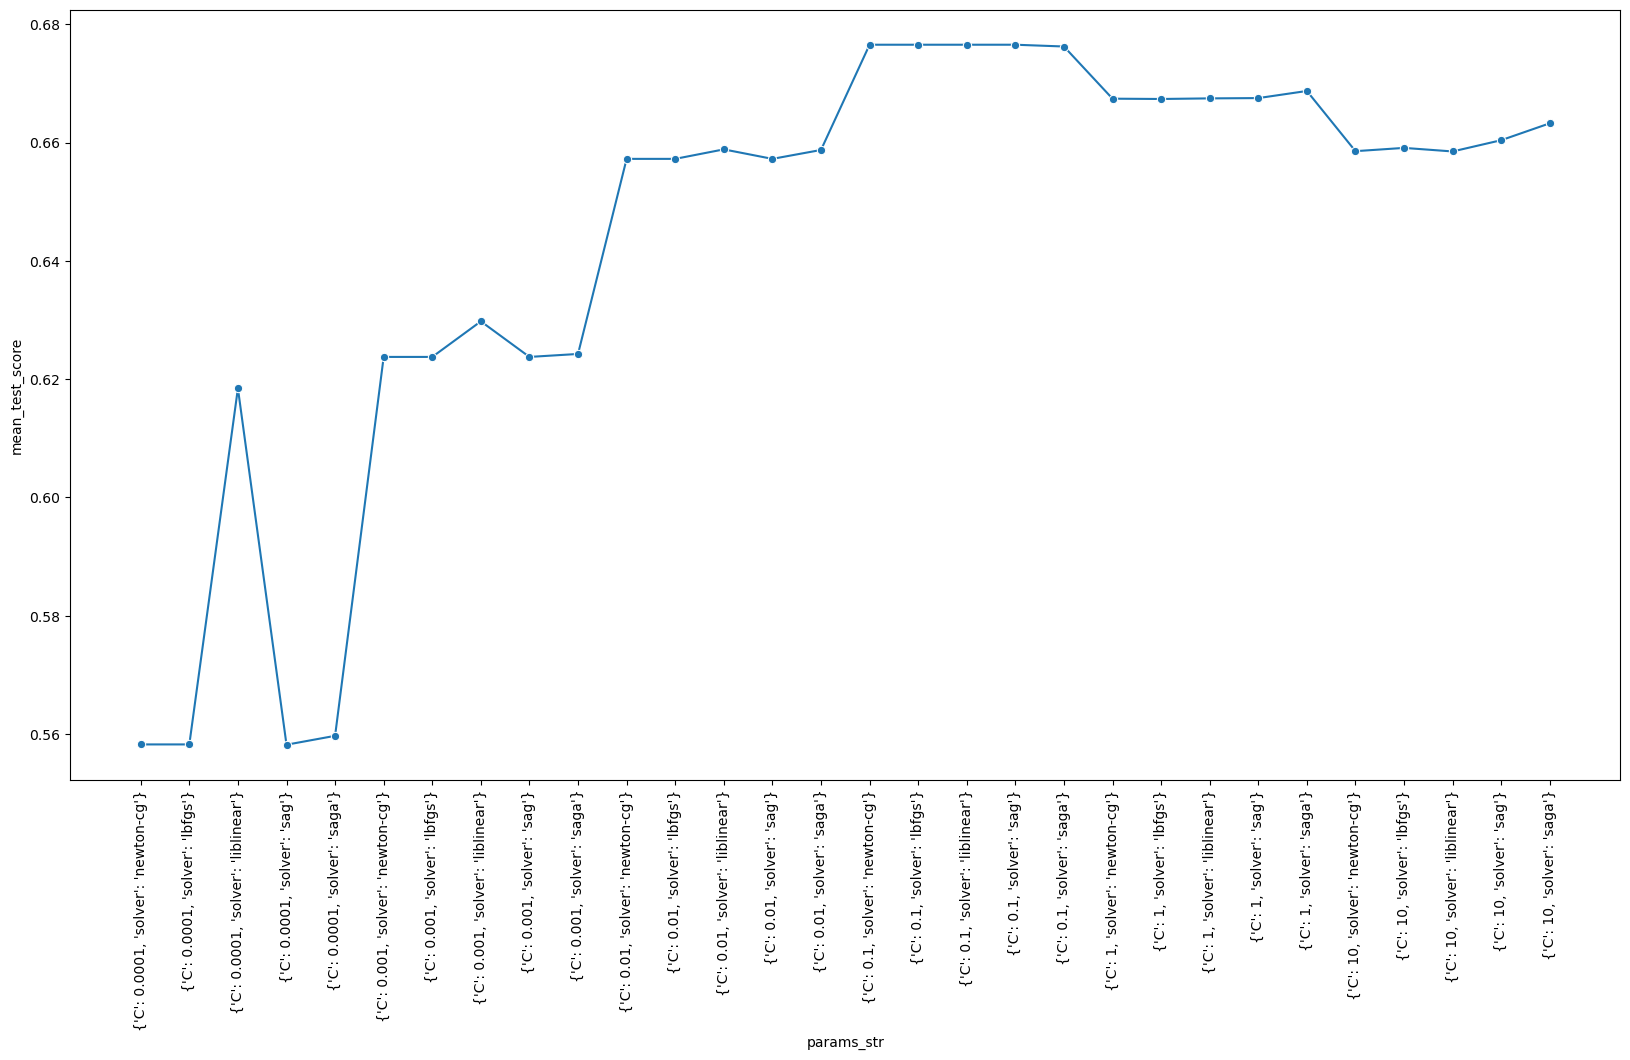

Los mejores parametros fueron: {'C': 0.1, 'solver': 'newton-cg'}
El mejor desempeno fue: 0.6765413533834586


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           0       0.67      0.73      0.70      5160
           1       0.68      0.62      0.65      4890

    accuracy                           0.67     10050
   macro avg       0.67      0.67      0.67     10050
weighted avg       0.67      0.67      0.67     10050

El ROC fue de: 0.6718373995339326
---------------------------------------------------------------------


In [7]:
modelo_logistic.fit(X_train, y_train)
resultados_logistic = aux.obtener_desempeno_modelo_en_grilla(modelo_logistic, X_test, y_test)


--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


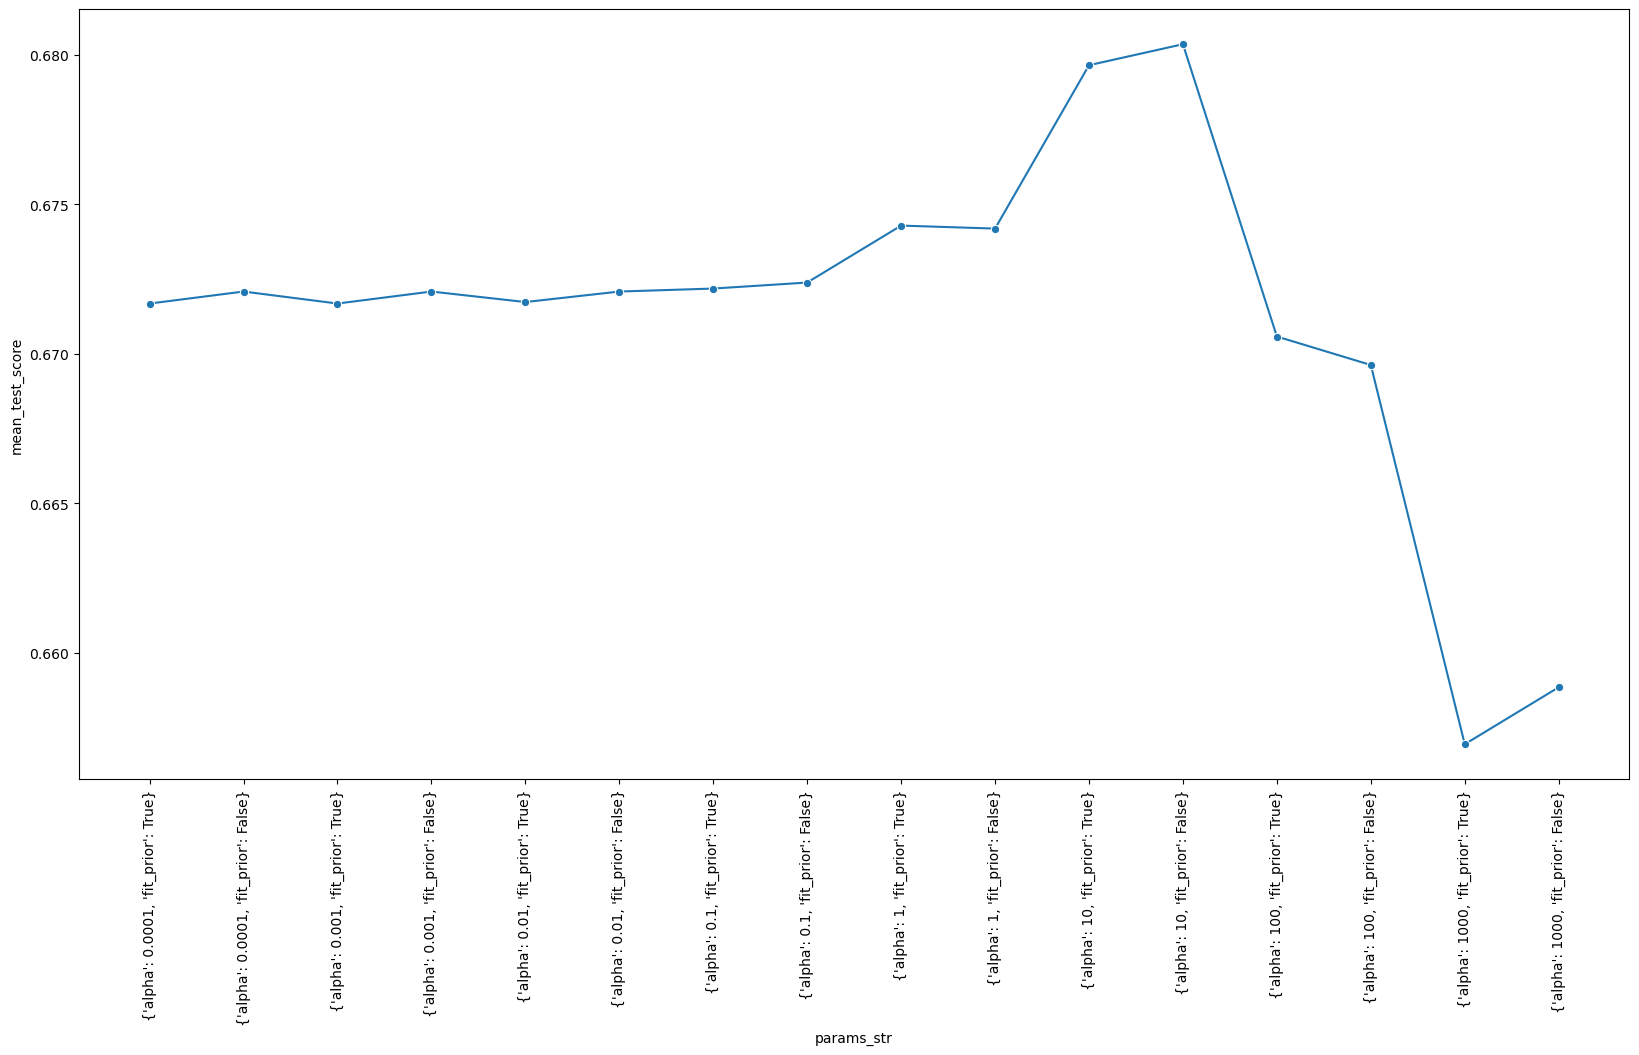

Los mejores parametros fueron: {'alpha': 10, 'fit_prior': False}
El mejor desempeno fue: 0.6803508771929825


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      5160
           1       0.67      0.65      0.66      4890

    accuracy                           0.67     10050
   macro avg       0.67      0.67      0.67     10050
weighted avg       0.67      0.67      0.67     10050

El ROC fue de: 0.6722951443382318
---------------------------------------------------------------------


In [8]:
modelo_naive_bayes.fit(X_train, y_train)
resultados_naimodelo_naive_bayes = aux.obtener_desempeno_modelo_en_grilla(
    modelo_naive_bayes, X_test, y_test
)


--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


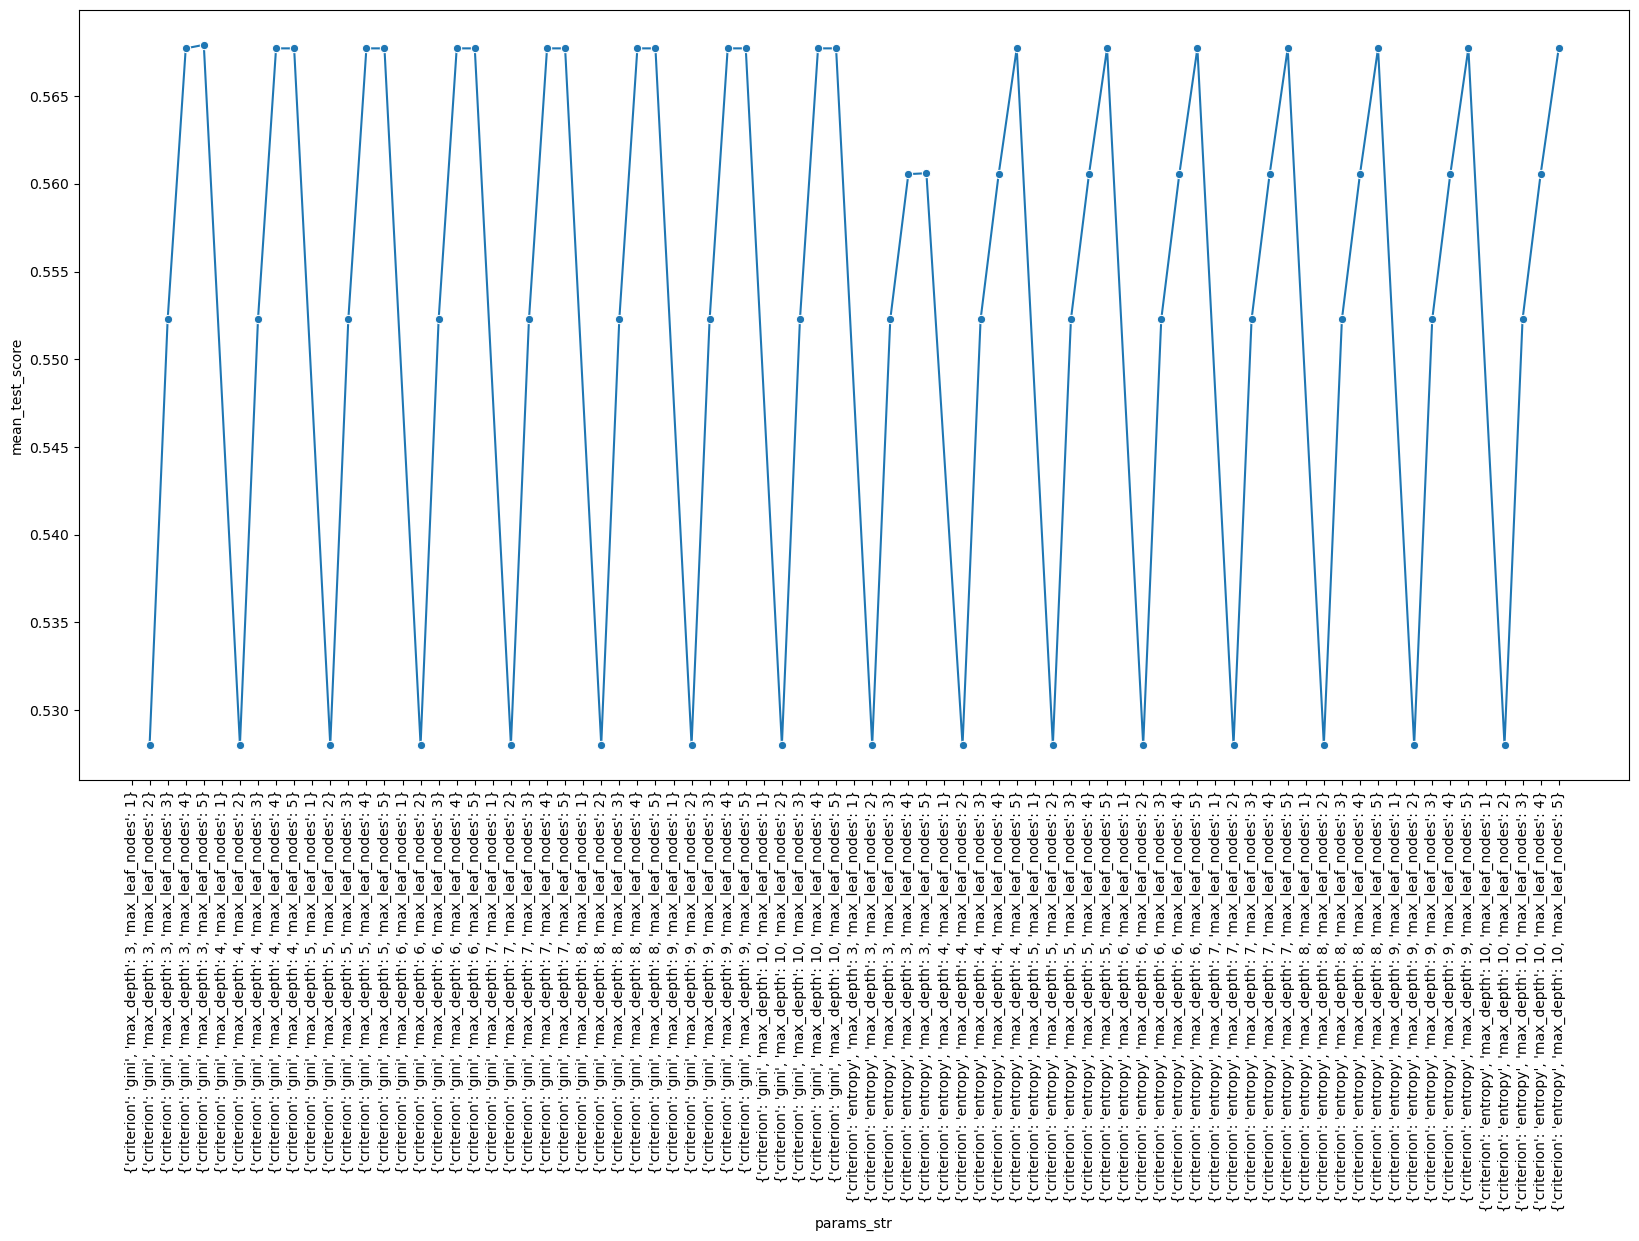

Los mejores parametros fueron: {'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': 5}
El mejor desempeno fue: 0.5679197994987469


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           0       0.55      0.96      0.70      5160
           1       0.80      0.17      0.28      4890

    accuracy                           0.57     10050
   macro avg       0.67      0.56      0.49     10050
weighted avg       0.67      0.57      0.49     10050

El ROC fue de: 0.563296594854235
---------------------------------------------------------------------


In [9]:
modelo_arbol.fit(X_train, y_train)
resultados_arbol = aux.obtener_desempeno_modelo_en_grilla(modelo_arbol, X_test, y_test)

--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


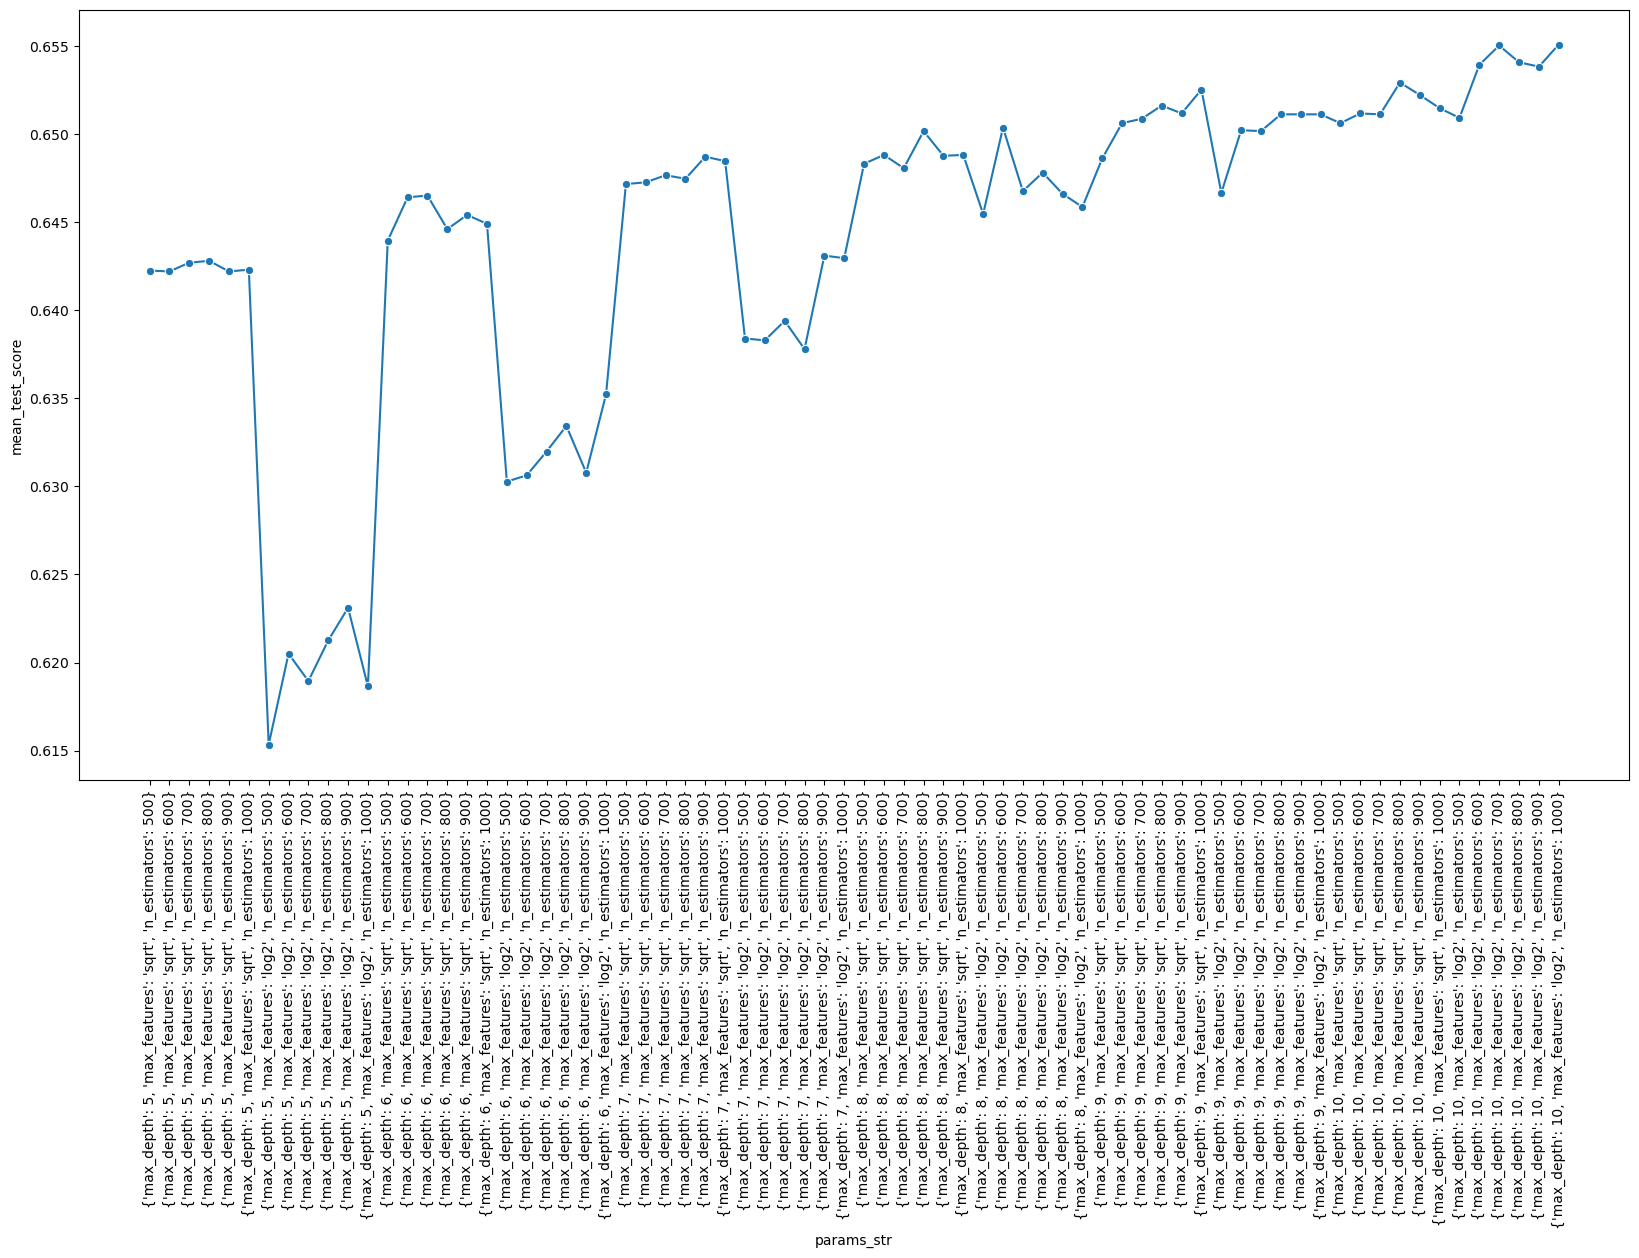

Los mejores parametros fueron: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 1000}
El mejor desempeno fue: 0.6550877192982456


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           0       0.62      0.87      0.72      5160
           1       0.76      0.44      0.56      4890

    accuracy                           0.66     10050
   macro avg       0.69      0.65      0.64     10050
weighted avg       0.69      0.66      0.64     10050

El ROC fue de: 0.6519855423978694
---------------------------------------------------------------------


In [10]:
modelo_random_forest.fit(X_train, y_train)
resultados_random_forest = aux.obtener_desempeno_modelo_en_grilla(
    modelo_random_forest, X_test, y_test
)


--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


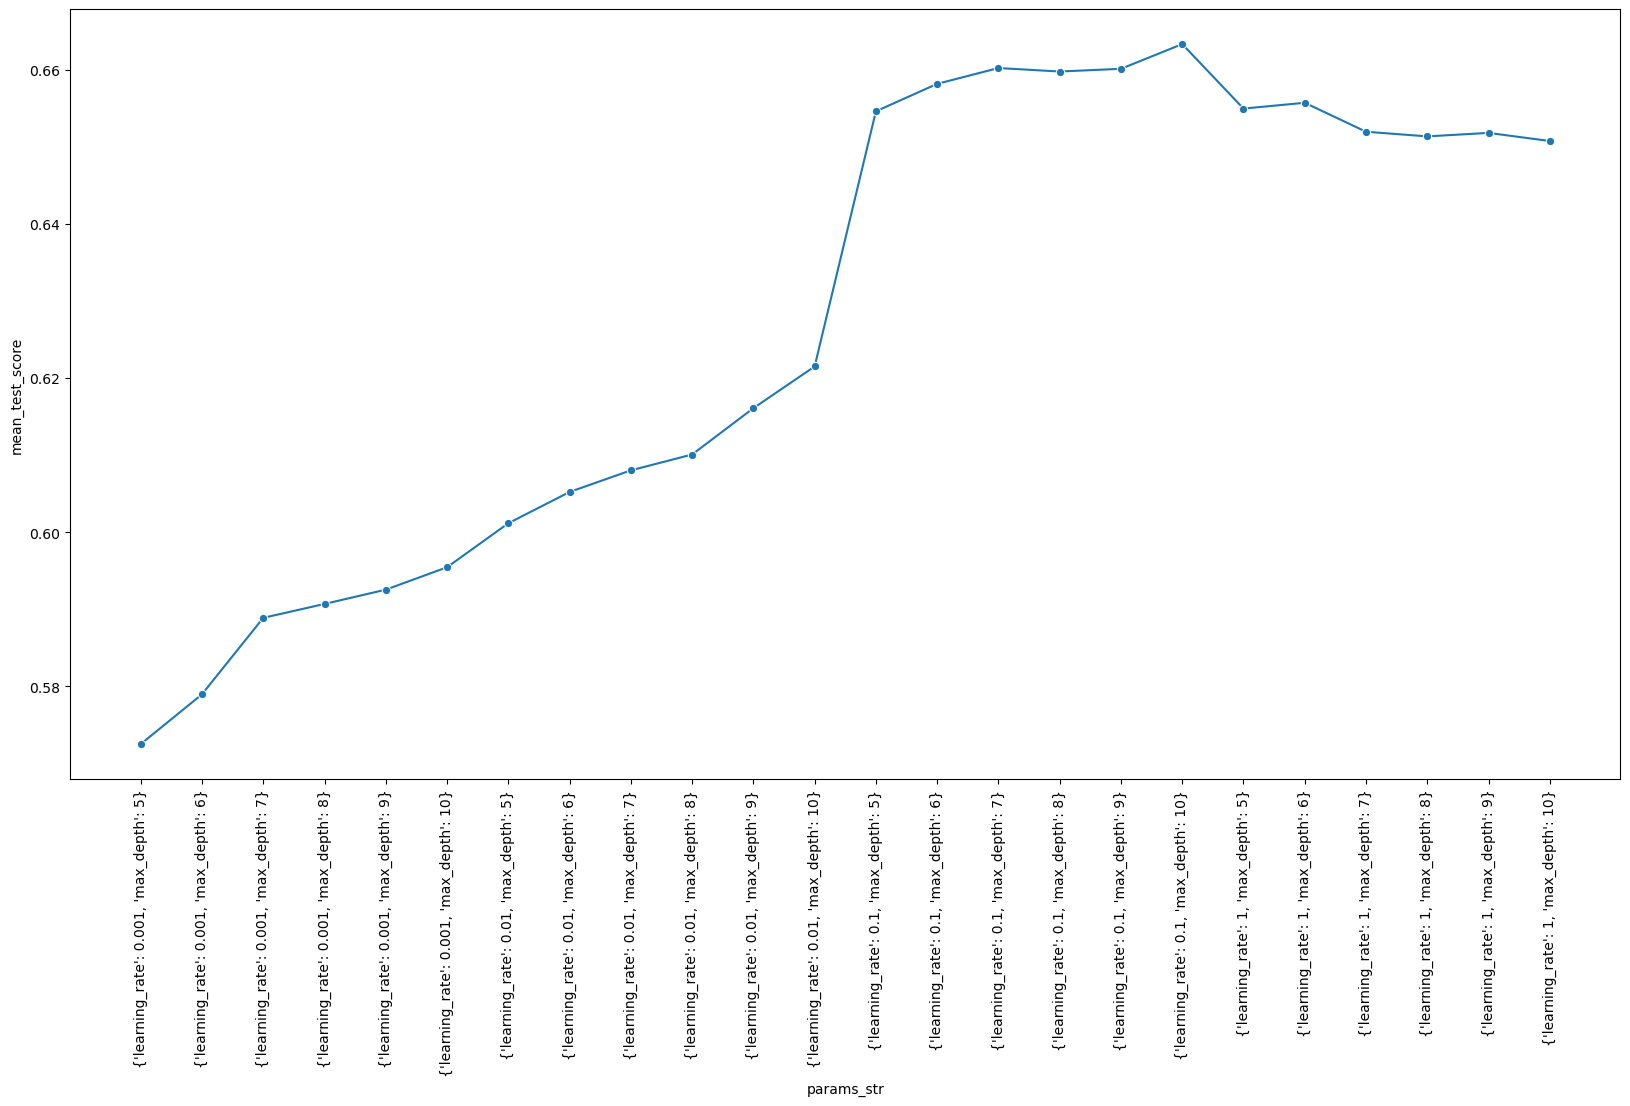

Los mejores parametros fueron: {'learning_rate': 0.1, 'max_depth': 10}
El mejor desempeno fue: 0.6633583959899749


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           0       0.63      0.78      0.70      5160
           1       0.69      0.53      0.60      4890

    accuracy                           0.66     10050
   macro avg       0.66      0.65      0.65     10050
weighted avg       0.66      0.66      0.65     10050

El ROC fue de: 0.6524022685119133
---------------------------------------------------------------------


In [11]:
modelo_gradient_boosting.fit(X_train, y_train)
resultados_gradient_boosting = aux.obtener_desempeno_modelo_en_grilla(
    modelo_gradient_boosting, X_test, y_test
)


## Reporte comparativo de desempenos

### Optimizado vs No Optimizado

- En la siguiente tabla se puede observar la diferencia en desempeno entre el modelo sin optimizar
(mostrado en el hito 2) y el modelo optimizado (con filtro de palabras).

|Modelo|Entrenamiento Accuracy|Validacion Accuracy|Validacion ROC|
|------|----------------------|-------------------|--------------|
|Logistico Sin Optimizacion|0.67|0.67|0.67|
|Logistico Con Optimizacion|0.68|0.67|0.67|
|Naive Bayes Sin Optimizacion|0.68|0.67|0.67|
|Naive Bayes Con Optimizacion|0.68|0.67|0.67|

- Se observa que tanto el modelo filtrado, como el modelo sin filtro presentan resultados muy similares
(casi identicos, el accuracy en entrenamiento del modelo logistico optimizado es mejor que el no optimizado). Esta tendencia se observa tanto en el conjunto de datos
de entrenamiento, como en el conjunto de datos de validacion.

- Por lo tanto, la optimizacion reduce considerablemente el costo computacional, y genera modelos
mas parsimoniosos.

### Todos los modelos

|Modelo|Entrenamiento Accuracy|Validacion Accuracy|Validacion ROC|
|------|----------------------|-------------------|--------------|
|Logistico|0.67|0.67|0.67|
|Naive Bayes|0.68|0.67|0.67|
|Arbol de clasificacion|0.57|0.57|0.56|
|Random Forest|0.66|0.66|0.65|
|Gradient Boosting|0.66|0.66|0.65|

- Se puede observar que los mejores modelos de clasificacion (segun el valor ROC) fueron el
modelo de regresion logistica o naive bayes. Ambos modelos presentaron un desempeno identico (naive bayes levemente mejor),
tanto en el conjunto de entrenamiento como en el de validacion. Ademas, fueron los modelos que
tuvieron el menor coste computacional, demorando ~8 y ~2 segundos en entrenar, respectivamente.

- El peor modelo fue el arbol de clasificacion, con un valor de ROC de 0.56. Por lo tanto, clasifica
en 6% mejor que un clasificador aleatorio.

- El modelo de Random Forest y Gradient Boosting fueron los modelos mas costosos computacionalmente,
demorando ~3 y ~9 minutos en entrenar, respectivamente. A pesar de su alto costo computacional,
estos modelos tuvieron un resultado comparable (levemente peor) al modelo logistico o naive bayes.

- El valor ROC promedio de los 5 modelos fue de 0.64.

# Exportacion de Mejores Modelos

Teniendo en cuenta los resultados anteriores, los mejores modelos son el modelo 
naive bayes y de regeresion logistica. Por lo tanto, ambos seran exportados para validacion externa.

In [15]:
modelos_a_exportar = {
    "javier_rojas-modelo-1.pickle": modelo_naive_bayes,
    "javier_rojas-modelo-2.pickle": modelo_logistic,
}

In [17]:
for archivo, modelo in modelos_a_exportar.items():
    with open(archivo, "wb") as file:
        pickle.dump(modelo, file)